In [1]:
from sympy import pi, cos, sin, symbols
from sympy.utilities.lambdify import implemented_function
import pytest

from sympde.calculus import grad, dot
from sympde.calculus import laplace
from sympde.topology import ScalarFunctionSpace
from sympde.topology import element_of
from sympde.topology import NormalVector
from sympde.topology import Square
from sympde.topology import Union
from sympde.expr     import BilinearForm, LinearForm, integral
from sympde.expr     import Norm
from sympde.expr     import find, EssentialBC
from sympde.expr.expr import linearize

from psydac.fem.basic          import FemField
from psydac.api.discretization import discretize

x,y,z = symbols('x1, x2, x3')

# Non-Linear Poisson in 2D

In this section, we consider the non-linear Poisson problem:

$$
-\nabla \cdot \left( (1+u^2) \nabla u \right) = f, \Omega
\\
u = 0, \partial \Omega
$$
where $\Omega$ denotes the unit square.

For testing, we shall take a function $u$ that fulfills the boundary condition, the compute $f$ as

$$
f(x,y) = -\nabla^2 u - F(u)
$$

The weak formulation is

$$
\int_{\Omega} (1+u^2) \nabla u \cdot \nabla v ~ d\Omega = \int_{\Omega} f v ~d\Omega, \quad \forall v \in \mathcal{V}
$$

For the sack of generality, we shall consider the linear form

$$
G(v;u,w) := \int_{\Omega} (1+w^2) \nabla u \cdot \nabla v ~ d\Omega, \quad \forall u,v,w \in \mathcal{V}
$$


Our problem is then

$$
\mbox{Find } u \in \mathcal{V}, \mbox{such that}\\
G(v;u,u) = l(v), \quad \forall v \in \mathcal{V}
$$

where

$$
l(v) := \int_{\Omega} f v ~d\Omega, \quad \forall v \in \mathcal{V}
$$

#### Topological domain

In [2]:
#==============================================================================
def get_boundaries(*args):

    if not args:
        return ()
    else:
        assert all(1 <= a <= 4 for a in args)
        assert len(set(args)) == len(args)

    boundaries = {1: {'axis': 0, 'ext': -1},
                  2: {'axis': 0, 'ext':  1},
                  3: {'axis': 1, 'ext': -1},
                  4: {'axis': 1, 'ext':  1}}

    return tuple(boundaries[i] for i in args)

dir_zero_boundary    = get_boundaries(1, 2, 3, 4)
dir_nonzero_boundary = get_boundaries()

domain = Square()

B_dirichlet_0 = Union(*[domain.get_boundary(**kw) for kw in dir_zero_boundary])
B_dirichlet_i = Union(*[domain.get_boundary(**kw) for kw in dir_nonzero_boundary])
B_dirichlet   = Union(B_dirichlet_0, B_dirichlet_i)

#### Function Space

In [3]:
V  = ScalarFunctionSpace('V', domain)

#### Defining the Linear form $G$

In [4]:
u  = element_of(V, name='u')
v  = element_of(V, name='v')
w  = element_of(V, name='w')

# Linear form g: V --> R
g = LinearForm(v, integral(domain, (1+w**2)*dot(grad(u), grad(v))))

#### Defining the Linear form L

In [5]:
solution = sin(pi*x)*sin(pi*y)
f = 2*pi**2*(sin(pi*x)**2*sin(pi*y)**2 + 1)*sin(pi*x)*sin(pi*y) - 2*pi**2*sin(pi*x)**3*sin(pi*y)*cos(pi*y)**2 - 2*pi**2*sin(pi*x)*sin(pi*y)**3*cos(pi*x)**2

In [6]:
# Linear form l: V --> R
l = LinearForm(v, integral(domain, f * v))

### Picard Method

$$
\mbox{Find } u_{n+1} \in \mathcal{V}_h, \mbox{such that}\\
G(v;u_{n+1},u_n) = l(v), \quad \forall v \in \mathcal{V}_h
$$

### Newton Method

Let's define 
$$
F(v;u) := G(v;u,u) -l(v), \quad \forall v \in \mathcal{V}
$$

Newton method writes
$$
\mbox{Find } u_{n+1} \in \mathcal{V}_h, \mbox{such that}\\
F^{\prime}(\delta u,v; u_n) = - F(v;u_n), \quad \forall v \in \mathcal{V} \\
u_{n+1} := u_{n} + \delta u, \quad \delta u \in \mathcal{V}
$$

#### Computing $F^{\prime}$ the derivative of $F$

**SymPDE** allows you to linearize a linear form and get a bilinear form, using the function **linearize**

In [7]:
F = LinearForm(v, g(v,w=u)-l(v))
du  = element_of(V, name='du')

Fprime = linearize(F, u, trials=du)

## Picard Method

#### Abstract Model

In [8]:
un  = element_of(V, name='un')

# Bilinear form a: V x V --> R
a = BilinearForm((u, v), g(v,w=un))

# Dirichlet boundary conditions
bc = [EssentialBC(u, 0, B_dirichlet_0)]

# Variational problem
equation   = find(u, forall=v, lhs=a(u, v), rhs=l(v), bc=bc)

# Error norms
error  = u - solution
l2norm = Norm(error, domain, kind='l2')

#### Discretization

In [9]:
# Create computational domain from topological domain
domain_h = discretize(domain, ncells=[16,16], comm=None)

# Discrete spaces
Vh = discretize(V, domain_h, degree=[2,2])

# Discretize equation using Dirichlet bc
equation_h = discretize(equation, domain_h, [Vh, Vh])

# Discretize error norms
l2norm_h = discretize(l2norm, domain_h, Vh)

#### Picard solver

In [10]:
def picard(niter=10):
    # TODO improve
    Un = FemField( Vh, Vh.vector_space.zeros() )

    for i in range(niter):
        x  = equation_h.solve(un=Un)
        Un = FemField( Vh, x )

        # Compute error norms
        l2_error = l2norm_h.assemble(u=Un)

        print('l2_error = ', l2_error)
        
    return Un

In [11]:
picard(niter=5)

l2_error =  0.10416232003536031
l2_error =  0.02818070437799316
l2_error =  0.01577620371136043
l2_error =  0.010677715881049122
l2_error =  0.007942521545142769


## Newton Method

#### Abstract Model

In [12]:
# Dirichlet boundary conditions
bc = [EssentialBC(du, 0, B_dirichlet_0)]

# Variational problem
equation   = find(du, forall=v, lhs=Fprime(du, v,u=un), rhs=-F(v,u=un), bc=bc)

#### Discretization

In [13]:
# Create computational domain from topological domain
domain_h = discretize(domain, ncells=[16,16], comm=None)

# Discrete spaces
Vh = discretize(V, domain_h, degree=[2,2])

# Discretize equation using Dirichlet bc
equation_h = discretize(equation, domain_h, [Vh, Vh])

# Discretize error norms
l2norm_h = discretize(l2norm, domain_h, Vh)

#### Newton Solver

In [14]:
def newton(niter=10):
    # TODO improve
    Un = FemField( Vh, Vh.vector_space.zeros() )

    for i in range(niter):
        xn = Un.coeffs
        x  = equation_h.solve(un=Un)
        Un = FemField( Vh, x + xn )

        # Compute error norms
        l2_error = l2norm_h.assemble(u=Un)

        print('l2_error = ', l2_error)
        
    return Un

In [17]:
un = newton(niter=3)

l2_error =  0.4059744621538083
l2_error =  0.2623750400995968
l2_error =  0.11438672581262425


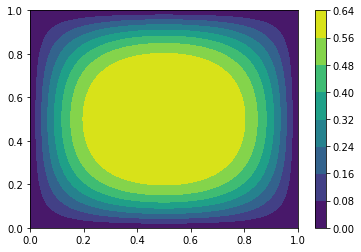

In [23]:
from matplotlib import pyplot as plt
from simplines import plot_field_2d

nbasis = [w.nbasis for w in Vh.spaces]
p1,p2 = Vh.degree
x = un.coeffs._data[p1:-p1,p2:-p2]
u = x.reshape(nbasis)
plot_field_2d(Vh.knots, Vh.degree, u) ; plt.colorbar()

In [19]:
18*18

324

In [22]:
(18+4)**2

484